## Introduction:

This code is a convolutional neural network implementation for the **CIFAR10 dataset**. The CIFAR10 dataset is a collection of **60,000 32x32 color images in 10 classes, with 6,000 images per class**. There were initially 50,000 training images and 10,000 test images. However, to prevent overfitting and keeping a better track of the training process I randomly selected 10,000 images from training set to create a validation set. Then, I augmented 30,000 images from the remaining training set and added the augmented images to trainin set. So in total, I have **70,000** training images, **10,000** validation images and **10,000** test images. The 10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

The implementation uses **PyTorch** deep learning framework, which is a widely used and well-documented framework for deep learning. The code consists of the following main parts:

**Data Preprocessing:** The CIFAR10 dataset is loaded and preprocessed using torchvision.transforms module, which applies normalization and data augmentation transforms to the images.

**Model Definition:** The model architecture is defined using the nn.Module class of PyTorch. **The model consists of 2 convolutional layers, followed by 2 fully connected layers**.

**Training:** The model is trained using the Adam optimizer and Cross-Entropy loss function. The training is done for 220 epochs on a GPU.

**Evaluation:** The accuracy of the trained model is evaluated on the test set.

The code achieves a **test accuracy of around 86%**, which is a good result considering the complexity of the CIFAR10 dataset.

In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam
import random

In [2]:
# Assign device to gpu
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
device

device(type='cuda')

In [3]:
# Define a set of transformations to apply to the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(), # Convert images to PyTorch tensors
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize pixel values to a mean of 0.5 and standard deviation of 0.5

# Define batch size for data loaders
batch_size = 50

# Load the CIFAR-10 training set and split it into a training set of 40,000 images and a validation set of 10,000 images
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])

# Load the validation set into a data loader with the specified batch size and 2 worker threads for parallel loading
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 test set into a data loader with the specified batch size and 2 worker threads for parallel loading
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# Define a tuple of the 10 categories in the CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(trainset) # Number of training images

40000

In [5]:
# Define a set of random augmentations to apply to images in the dataset
augmentation_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Flip images horizontally with probability 0.5
    transforms.RandomRotation(degrees=15), # Rotate images by a random angle between -15 and 15 degrees
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)), # Crop and resize images to a random size between 80% and 100% of the original size
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5) # Apply a random perspective transformation to images with probability 0.5
])

In [6]:
# Randomly select 30,000 indices from the range of indices of the training set
aug_idx = random.sample([i for i in range(len(trainset))], 30000)

# Create an empty list to hold the new augmented images
augmented_data = []

# Loop through the selected indices
for idx in aug_idx:
    # Load the image and its corresponding label
    img, label = trainset[idx]

    # Apply the predefined augmentation transforms to the image
    augmented_img = augmentation_transforms(img)

    # Append the augmented image and its original label as a tuple to the list of augmented data
    augmented_data.append((augmented_img,label))


In [7]:
# Combine the original training set and the augmented data to create a single dataset
combined_data = torch.utils.data.ConcatDataset([trainset, augmented_data])

# Create the data loader for the combined dataset, which will shuffle the data during each epoch
trainloader = torch.utils.data.DataLoader(combined_data, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
len(trainloader)*batch_size # New number of training images

70000

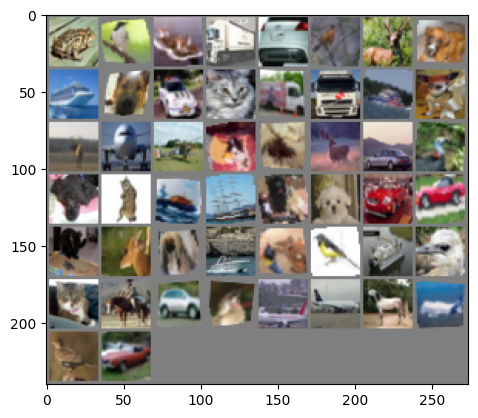

frog  bird  ship  truck car   bird  deer  dog   ship  dog   car   cat   truck truck ship  dog   deer  plane plane dog   deer  deer  car   bird  dog   cat   ship  ship  dog   dog   car   car   cat   deer  dog   ship  deer  bird  ship  bird  cat   horse car   bird  plane plane horse plane bird  car  


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define a helper function to display images
def imshow(img):
    # Unnormalize the image
    img = img / 2 + 0.5
    # Convert the image to a numpy array
    npimg = img.numpy()
    # Transpose the array to change the order of dimensions (3, 32, 32 --> 32, 32, 3)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Get a batch of random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the helper function defined above
imshow(torchvision.utils.make_grid(images))

# Print the labels for each image in the batch
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3) 
        self.batchnorm1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 64, 3) 
        self.batchnorm2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3) 
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, 3) 
        self.batchnorm4 = nn.BatchNorm2d(128)
        
        # Define the fully connected layers
        self.linear1 = nn.Linear(128*5*5, 128) 
        self.linear2 = nn.Linear(128, 10)
        
        # Define the dropout layer, activation function, and pooling layer
        self.dropout = nn.Dropout(0.4)
        self.R = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        # Initialize empty lists to store training and validation losses
        self.history = []
        self.batch_history = []
        self.val_history = []
        
    def forward(self, x):
        
        # Convert input data to the appropriate data type and device
        x = x.to(dtype=torch.float32)
        x = x.to(device)
        
        # Pass input through the convolutional layers
        x = self.conv1(x) # N, 3, 32, 32 --> N, 64, 30, 30
        x = self.R(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)

        x = self.conv2(x) # N, 64, 30, 30 --> N, 64, 28, 28
        x = self.R(x)
        x = self.batchnorm2(x)
        x = self.pool(x) # N, 64, 28, 28 --> N, 64, 14, 14
        x = self.dropout(x)
        
        x = self.conv3(x) # N, 64, 14, 14 --> N, 128, 12, 12
        x = self.R(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = self.conv4(x) # N, 128, 12, 12 --> N, 128, 10, 10
        x = self.R(x)
        x = self.batchnorm4(x)
        x = self.pool(x) # N, 128, 10, 10 --> N, 128, 5, 5
        x = self.dropout(x)
        
        # Flatten the output of the convolutional layers
        x = torch.flatten(x, 1)

        # Pass the flattened output through the fully connected layers
        x = self.linear1(x)
        x = self.R(x)
        x = self.dropout(x)

        x = self.linear2(x)
        
        return x

In [15]:
def train(dl, model, optimizer, n_epochs=10, valdl=None):
    # Define the loss function
    L = nn.CrossEntropyLoss()
    
    # Loop over the number of epochs
    for epoch in range(n_epochs):
        # Set the model to train mode
        model.train()
        
        # Initialize empty lists to store the batch loss and validation batch loss
        batch_loss = []
        val_batch_loss = []
        for x, y in dl:
            # Move data to device (Data and the model has to be assigned to the same device)
            y = y.to(device)
            
            # Zero out the optimizer gradients at the beginning of each epoch
            optimizer.zero_grad()
            
            # Forward pass
            out = model(x)
            
            # Compute the loss
            loss = L(out, y)
            
            # Backward pass
            loss.backward()
            
            # Update the optimizer
            optimizer.step()
            
            # Append the batch loss to the list
            batch_loss.append(loss.item())
            
            # Append the batch loss to the model batch history
            model.batch_history.append(loss.item())
        
        # Append the mean batch loss of the epoch to the model history
        model.history.append(np.array(batch_loss).mean())
        
        # If a validation data loader is provided
        if valdl:
            # Disable gradient computation
            with torch.no_grad():
                for valx, valy in valdl:
                    # Move data to device
                    valy = valy.to(device)
                    
                    # Forward pass
                    out = model(valx)
                    
                    # Compute the loss
                    loss = L(out, valy)
                    
                    # Append the validation batch loss to the list
                    val_batch_loss.append(loss.item())
                    
                # Append the mean validation batch loss to the model validation history
                model.val_history.append(np.array(val_batch_loss).mean())
                
                # Print the epoch number, training loss, and validation loss
                print(f'Epoch {len(model.history)}: Loss: {np.array(batch_loss).mean():.4f}, ValLoss: {np.array(val_batch_loss).mean():.4f}')
        # If no validation data loader is provided
        else:
            # Print the epoch number and training loss
            print(f'Epoch {len(model.history)}: Loss: {np.array(batch_loss).mean():.4f}')
            
            
def evaluate(dl, model):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize variables to track correct and incorrect predictions
    true, false = 0, 0
    
    # Loop over the data loader
    for xs, ys in dl:
        # Move data to device
        xs, ys = xs.to(device), ys.to(device)
        
        # Forward pass
        preds = model(xs)
        
        # Convert predictions to class labels
        preds = [pred.argmax() for pred in preds]
        
        # Loop over the predictions and true labels
        for pred, y in zip(preds, ys):
            
            # Increment the correct count if the prediction is correct
            if pred == y:
                true += 1
            # Increment the incorrect count if the prediction is incorrect
            else:
                false += 1
                
    # Compute the accuracy
    accuracy = true/(true+false)
    
    # Return the accuracy
    return accuracy 

In [19]:
# Create the model and move it to device
model = Net()
model = model.to(device)

In [20]:
# Initialize the Adam optimizer with it's default values and model parameters
optimizer = Adam(model.parameters())

In [21]:
# Train for 200 epochs
train(trainloader, model, optimizer, n_epochs=200, valdl=valloader)

Epoch 1: Loss: 1.5175, ValLoss: 1.2353
Epoch 2: Loss: 1.1905, ValLoss: 1.0543
Epoch 3: Loss: 1.0535, ValLoss: 0.9484
Epoch 4: Loss: 0.9773, ValLoss: 0.9038
Epoch 5: Loss: 0.9221, ValLoss: 0.8814
Epoch 6: Loss: 0.8770, ValLoss: 0.8493
Epoch 7: Loss: 0.8427, ValLoss: 0.8193
Epoch 8: Loss: 0.8108, ValLoss: 0.8027
Epoch 9: Loss: 0.7820, ValLoss: 0.7990
Epoch 10: Loss: 0.7645, ValLoss: 0.7839
Epoch 11: Loss: 0.7391, ValLoss: 0.7708
Epoch 12: Loss: 0.7167, ValLoss: 0.7768
Epoch 13: Loss: 0.6980, ValLoss: 0.7711
Epoch 14: Loss: 0.6820, ValLoss: 0.7356
Epoch 15: Loss: 0.6732, ValLoss: 0.7267
Epoch 16: Loss: 0.6572, ValLoss: 0.7394
Epoch 17: Loss: 0.6460, ValLoss: 0.7377
Epoch 18: Loss: 0.6413, ValLoss: 0.7287
Epoch 19: Loss: 0.6251, ValLoss: 0.7344
Epoch 20: Loss: 0.6171, ValLoss: 0.7295
Epoch 21: Loss: 0.6090, ValLoss: 0.7069
Epoch 22: Loss: 0.6047, ValLoss: 0.7182
Epoch 23: Loss: 0.5913, ValLoss: 0.7101
Epoch 24: Loss: 0.5855, ValLoss: 0.7046
Epoch 25: Loss: 0.5855, ValLoss: 0.6984
Epoch 26:

In [22]:
print(evaluate(trainloader, model), evaluate(valloader, model), evaluate(testloader, model))

0.9810285714285715 0.8665 0.8623


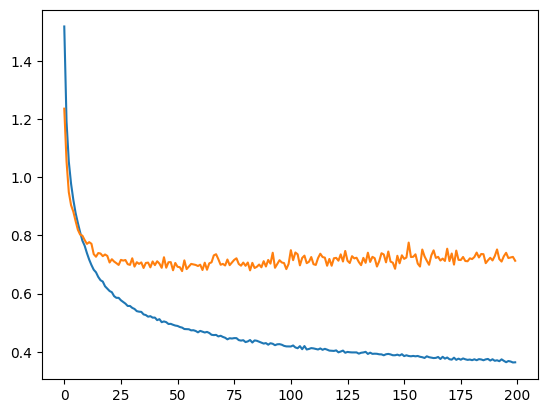

In [27]:
plt.plot(model.history)
plt.plot(model.val_history)
plt.show()

In [23]:
# torch.save(model, 'cifar10_model.pt')

In [13]:
model = torch.load('cifar10_model.pt')
model.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=3200, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (R): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [16]:
print(evaluate(trainloader, model), evaluate(valloader, model), evaluate(testloader, model))

0.9104714285714286 0.9599 0.8623
